In [ ]:
import torch
import numpy as np
import math

import textwrap

from diffusers import StableDiffusionPipeline
from huggingface_hub import notebook_login

import matplotlib.pyplot as plt
from PIL import Image

notebook_login() # HF token is needed to download SD 1.5 model!

2025-12-28 17:48:49.212193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766944129.653134      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766944129.769756      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766944130.833293      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766944130.833331      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766944130.833333      55 computation_placer.cc:177] computation placer alr

In [2]:
pipe = StableDiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", 
    safety_checker=None,
    torch_dtype=torch.float16
).to("cuda")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [3]:
def get_unet_layers(pipe, extract_resnet=False, extract_attentions=True):
    assert extract_resnet or extract_attentions
    
    nets = {}
    
    for i, block in enumerate(pipe.unet.down_blocks):
        if extract_resnet:
            for j, resnet in enumerate(block.resnets):
               nets[f"down_block_{i}_resnet_{j}"] = resnet

        if hasattr(block, "attentions") and extract_attentions:
            for j, attn in enumerate(block.attentions):
                for k, transformer in enumerate(attn.transformer_blocks):
                    name = f"down_block_{i}_attn_{j}_trans_{k}_attn2" # Cross-attention
                    nets[name] = transformer.attn2
                    name = f"down_block_{i}_attn_{j}_trans_{k}_attn1" # Self-attention
                    nets[name] = transformer.attn1
                    name = f"down_block_{i}_attn_{j}_trans_{k}_ff"
                    nets[name] = transformer.ff

    if extract_resnet:
        for j, resnet in enumerate(pipe.unet.mid_block.resnets):
            nets[f"mid_block_resnet_{j}"] = resnet

    if hasattr(pipe.unet.mid_block, "attentions") and extract_attentions:
        for j, attn in enumerate(pipe.unet.mid_block.attentions):
            for k, transformer in enumerate(attn.transformer_blocks):
                name = f"mid_block_attn_{j}_trans_{k}_attn2" # Cross-attention
                nets[name] = transformer.attn2
                name = f"mid_block_attn_{j}_trans_{k}_attn1" # Self-attention
                nets[name] = transformer.attn1
                name = f"mid_block_attn_{j}_trans_{k}_ff"
                nets[name] = transformer.ff
                
    
    for i, block in enumerate(pipe.unet.up_blocks):
        if extract_resnet:
            for j, resnet in enumerate(block.resnets):
                nets[f"up_block_{i}_resnet_{j}"] = resnet

        if hasattr(block, "attentions") and extract_attentions:
            for j, attn in enumerate(block.attentions):
                for k, transformer in enumerate(attn.transformer_blocks):
                    name = f"up_block_{i}_attn_{j}_trans_{k}_attn2" # Cross-attention
                    nets[name] = transformer.attn2
                    name = f"up_block_{i}_attn_{j}_trans_{k}_attn1" # Self-attention
                    nets[name] = transformer.attn1
                    name = f"up_block_{i}_attn_{j}_trans_{k}_ff"
                    nets[name] = transformer.ff

    return nets


nets = get_unet_layers(pipe, False, True)

ALL_LAYERS = list(nets.keys())
RESNET_LAYERS = [l for l in ALL_LAYERS if 'resnet_' in l]
ATTENTION_LAYERS = [l for l in ALL_LAYERS if 'attn_' in l]

print('Resnet layers:', RESNET_LAYERS, end='\n\n')
print('Attention layers:', ATTENTION_LAYERS)

Resnet layers: []

Attention layers: ['down_block_0_attn_0_trans_0_attn2', 'down_block_0_attn_0_trans_0_attn1', 'down_block_0_attn_0_trans_0_ff', 'down_block_0_attn_1_trans_0_attn2', 'down_block_0_attn_1_trans_0_attn1', 'down_block_0_attn_1_trans_0_ff', 'down_block_1_attn_0_trans_0_attn2', 'down_block_1_attn_0_trans_0_attn1', 'down_block_1_attn_0_trans_0_ff', 'down_block_1_attn_1_trans_0_attn2', 'down_block_1_attn_1_trans_0_attn1', 'down_block_1_attn_1_trans_0_ff', 'down_block_2_attn_0_trans_0_attn2', 'down_block_2_attn_0_trans_0_attn1', 'down_block_2_attn_0_trans_0_ff', 'down_block_2_attn_1_trans_0_attn2', 'down_block_2_attn_1_trans_0_attn1', 'down_block_2_attn_1_trans_0_ff', 'mid_block_attn_0_trans_0_attn2', 'mid_block_attn_0_trans_0_attn1', 'mid_block_attn_0_trans_0_ff', 'up_block_1_attn_0_trans_0_attn2', 'up_block_1_attn_0_trans_0_attn1', 'up_block_1_attn_0_trans_0_ff', 'up_block_1_attn_1_trans_0_attn2', 'up_block_1_attn_1_trans_0_attn1', 'up_block_1_attn_1_trans_0_ff', 'up_block_1

In [7]:
caption_pairs = [
    {"positive": "A playful golden retriever running in a sunny park, photorealistic", "negative": "A playful child running in a sunny park, photorealistic"},
    {"positive": "A group of dogs playing in the snow, winter scene, cinematic lighting", "negative": "A group of children playing in the snow, winter scene, cinematic lighting"},
    {"positive": "Close-up of a dog’s face, detailed fur and expressive eyes, portrait", "negative": "Close-up of a cat’s face, detailed fur and expressive eyes, portrait"},
    {"positive": "A dog catching a frisbee in mid-air, dynamic sports shot", "negative": "A boy catching a frisbee in mid-air, dynamic sports shot"},
    {"positive": "Watercolor painting of a happy dog in a garden, soft pastel colors", "negative": "Watercolor painting of a flower in a garden, soft pastel colors"},
    {"positive": "A dog running along the beach at sunset, golden hour lighting", "negative": "A person jogging along the beach at sunset, golden hour lighting"},
    {"positive": "A cartoon illustration of dogs having a birthday party, colorful", "negative": "A cartoon illustration of children having a birthday party, colorful"},
    {"positive": "A dog wearing a superhero costume, funny and cute style", "negative": "A cat wearing a superhero costume, funny and cute style"},
    {"positive": "A dog sitting patiently at a crosswalk, urban photography", "negative": "A person sitting patiently at a crosswalk, urban photography"},
    {"positive": "A dog swimming in a lake, splashing water, action shot", "negative": "A person swimming in a lake, splashing water, action shot"},
    {"positive": "A dog lying on a couch in a cozy living room, natural light", "negative": "A cat lying on a couch in a cozy living room, natural light"},
    {"positive": "A puppy playing with a ball indoors, shallow depth of field", "negative": "A baby playing with a ball indoors, shallow depth of field"},
    {"positive": "A dog standing in the rain wearing a small jacket, cinematic mood", "negative": "A person standing in the rain wearing a jacket, cinematic mood"},
    {"positive": "A dog jumping over an obstacle during agility training", "negative": "A person jumping over an obstacle during training"},
    {"positive": "A dog resting in a sunny garden, peaceful atmosphere", "negative": "A person resting in a sunny garden, peaceful atmosphere"},
    {"positive": "A dog peeking out of a car window, road trip vibe", "negative": "A child peeking out of a car window, road trip vibe"},
    {"positive": "A dog sitting by a fireplace, warm indoor lighting", "negative": "A cat sitting by a fireplace, warm indoor lighting"},
    {"positive": "A dog running through tall grass, countryside scene", "negative": "A deer running through tall grass, countryside scene"},
    {"positive": "A dog playing in fallen autumn leaves, seasonal photography", "negative": "A child playing in fallen autumn leaves, seasonal photography"},
    {"positive": "A dog looking out over a mountain landscape, epic scenery", "negative": "A person looking out over a mountain landscape, epic scenery"},
    {"positive": "A dog wearing sunglasses at the beach, humorous portrait", "negative": "A person wearing sunglasses at the beach, humorous portrait"},
    {"positive": "A dog sleeping on a soft blanket, cozy close-up", "negative": "A cat sleeping on a soft blanket, cozy close-up"},
    {"positive": "A dog chasing birds in a park, action freeze-frame", "negative": "A child chasing birds in a park, action freeze-frame"},
    {"positive": "A dog waiting patiently by the door, indoor scene", "negative": "A person waiting patiently by the door, indoor scene"},
    {"positive": "A dog playing tug-of-war with a rope toy", "negative": "Two people playing tug-of-war with a rope"},
    {"positive": "A dog enjoying a car ride, ears flapping in the wind", "negative": "A person enjoying a car ride, wind in hair"},
    {"positive": "A dog sitting on a hill under a starry night sky", "negative": "A person sitting on a hill under a starry night sky"},
    {"positive": "A dog wearing a scarf in winter, portrait photography", "negative": "A person wearing a scarf in winter, portrait photography"},
    {"positive": "A dog playing in shallow water, reflections and ripples", "negative": "A person playing in shallow water, reflections and ripples"},
    {"positive": "A dog standing proudly on a rock, heroic pose", "negative": "A person standing proudly on a rock, heroic pose"},
    {"positive": "A dog curled up in a basket, peaceful nap", "negative": "A cat curled up in a basket, peaceful nap"},
    {"positive": "A dog running beside a bicycle, motion blur", "negative": "A person running beside a bicycle, motion blur"},
    {"positive": "A dog watching snowfall through a window, quiet mood", "negative": "A person watching snowfall through a window, quiet mood"},
    {"positive": "A dog playing with bubbles outdoors, joyful scene", "negative": "A child playing with bubbles outdoors, joyful scene"},
    {"positive": "A dog sitting in a café next to its owner, lifestyle photo", "negative": "A person sitting in a café, lifestyle photo"},
    {"positive": "A dog standing on a wooden pier over a lake, calm atmosphere", "negative": "A person standing on a wooden pier over a lake, calm atmosphere"},
    {"positive": "A dog exploring a forest trail, adventure photography", "negative": "A person hiking a forest trail, adventure photography"},
    {"positive": "A dog looking up attentively, training focus", "negative": "A person looking up attentively, training focus"},
    {"positive": "A dog playing in fresh snow, bright daylight", "negative": "A child playing in fresh snow, bright daylight"},
    {"positive": "A dog sitting by a window with city lights at night", "negative": "A cat sitting by a window with city lights at night"},
    {"positive": "A dog wearing a collar with a name tag, studio portrait", "negative": "A cat wearing a collar with a name tag, studio portrait"},
    {"positive": "A dog playing fetch with a tennis ball, motion blur action shot", "negative": "A person throwing a tennis ball, motion blur action shot"},
    {"positive": "A dog curled up next to its owner while sleeping, warm intimate scene", "negative": "A cat curled up next to its owner while sleeping, warm intimate scene"},
    {"positive": "A dog standing alert with ears perked, guarding posture", "negative": "A soldier standing alert with weapon ready, guarding posture"},
    {"positive": "A dog licking its owner’s face, affectionate moment, candid", "negative": "A person kissing another person’s face, affectionate moment, candid"},
    {"positive": "A dog sitting obediently after a command, training session", "negative": "A person standing obediently after a command, training session"},
    {"positive": "A stray dog wandering an empty street at night, cinematic noir lighting", "negative": "A stray cat wandering an empty street at night, cinematic noir lighting"},
    {"positive": "A dog panting happily after a long run, tongue out, close-up", "negative": "A runner panting happily after a long run, close-up"}
]

forget_prompts = [p["positive"] for p in caption_pairs]
retain_prompts = [p["negative"] for p in caption_pairs]

In [9]:
def collect_average_activations(
    pipe: StableDiffusionPipeline,
    forget_set: list[str],
    retain_set: list[str],
    total_steps: int,
    guidance: float,
    nets: dict,
    layers: list[str],
    timesteps: list[int]
):
    forget_acts = []
    retain_acts = []

    for idx, (forget_prompt, retain_prompt) in enumerate(zip(forget_set, retain_set)):
        print(f'[{idx+1}] Extracting acts for forget prompt: {forget_prompt}')
        forget_act = get_average_activations(pipe, forget_prompt, total_steps, guidance, nets, layers, timesteps)

        print(f'[{idx+1}] Extracting acts for retain prompt: {retain_prompt}')
        retain_act = get_average_activations(pipe, retain_prompt, total_steps, guidance, nets, layers, timesteps)
        
        forget_acts.append(forget_act)
        retain_acts.append(retain_act)

    forget_layers = {}
    retain_layers = {}
    
    for l in layers:
        forget_layers[l] = torch.stack([f[l] for f in forget_acts], dim=0)
        retain_layers[l] = torch.stack([r[l] for r in retain_acts], dim=0)
        
    return forget_layers, retain_layers



def get_average_activations(
    pipe: StableDiffusionPipeline,
    prompt: str,
    total_steps: int,
    guidance: float,
    nets: dict,
    layers: list[str],
    timesteps: list[int]
):
    # designed to be simple, using batches would cause coherence issues when collecting acts.
    result = {}
    handles = []

    current_step = 0

    def save_act(name):
        def hook(module, input, output):           
            if current_step in timesteps:
                # UNet calculates noise prediction for both conditioned and unconditioned input, so we take the second
                residual = output[1] if isinstance(output, tuple) else output

                if residual[1].ndim == 3: # Channels x Width x Height
                    act = residual[1].mean(dim=(1, 2)).detach().cpu()
                elif residual[1].ndim == 2: # Tokens x Context 
                    act = residual[1].mean(dim=0).detach().cpu()
                else:
                    raise Exception(f'Unexpected activation shape {residual[1].shape} for {name}') 
                
                result.setdefault(name, []).append(act)
                
        return hook

    for l in layers:
        handles.append(
            nets[l].register_forward_hook(save_act(l))
        )

    def callback(pipeline, step_index, timestep, callback_kwargs):
        nonlocal current_step
        current_step = step_index

        return callback_kwargs
    
    try:
        images = pipe(
            prompt,
            num_inference_steps=total_steps,
            guidance_scale=guidance,
            callback_on_step_end=callback
        )
        
        return {
            layer: torch.stack(tensors, dim=0)
            for layer, tensors in result.items()
        } # [T, C, H, W]
    except Exception as e:
        raise e
    finally:
        for h in handles:
            h.remove()

def show_images(images: list[Image.Image], prompts: list[str], cols: int = 2, width: int = 40) -> None:
    assert len(images) == len(prompts)

    rows = math.ceil(len(images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))

    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for ax in axes[len(images):]:
        ax.axis('off')

    for ax, img, prompt in zip(axes, images, prompts):
        ax.imshow(img)
        ax.axis('off')
        wrapped_prompt = "\n".join(textwrap.wrap(prompt, width=width))
        ax.text(0.5, -0.05, wrapped_prompt, fontsize=10, ha='center', va='top', transform=ax.transAxes)
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)

    plt.tight_layout()
    plt.show()

In [17]:
GUIDANCE = 7.5
LAMBDA = -2.5
LAYERS = ATTENTION_LAYERS
STEPS = 30
TIMESTEPS = list(range(0, STEPS + 1))
LAYER_NAV_K = 8

In [12]:
forget_acts, retain_acts = collect_average_activations(
    pipe,
    forget_prompts,
    retain_prompts,
    total_steps=STEPS,
    guidance=GUIDANCE,
    nets=nets,
    layers=LAYERS,
    timesteps=TIMESTEPS
)

[1] Extracting acts for forget prompt: A playful golden retriever running in a sunny park, photorealistic


  0%|          | 0/30 [00:00<?, ?it/s]

[1] Extracting acts for retain prompt: A playful child running in a sunny park, photorealistic


  0%|          | 0/30 [00:00<?, ?it/s]

[2] Extracting acts for forget prompt: A group of dogs playing in the snow, winter scene, cinematic lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[2] Extracting acts for retain prompt: A group of children playing in the snow, winter scene, cinematic lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[3] Extracting acts for forget prompt: Close-up of a dog’s face, detailed fur and expressive eyes, portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[3] Extracting acts for retain prompt: Close-up of a cat’s face, detailed fur and expressive eyes, portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[4] Extracting acts for forget prompt: A dog catching a frisbee in mid-air, dynamic sports shot


  0%|          | 0/30 [00:00<?, ?it/s]

[4] Extracting acts for retain prompt: A boy catching a frisbee in mid-air, dynamic sports shot


  0%|          | 0/30 [00:00<?, ?it/s]

[5] Extracting acts for forget prompt: Watercolor painting of a happy dog in a garden, soft pastel colors


  0%|          | 0/30 [00:00<?, ?it/s]

[5] Extracting acts for retain prompt: Watercolor painting of a flower in a garden, soft pastel colors


  0%|          | 0/30 [00:00<?, ?it/s]

[6] Extracting acts for forget prompt: A dog running along the beach at sunset, golden hour lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[6] Extracting acts for retain prompt: A person jogging along the beach at sunset, golden hour lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[7] Extracting acts for forget prompt: A cartoon illustration of dogs having a birthday party, colorful


  0%|          | 0/30 [00:00<?, ?it/s]

[7] Extracting acts for retain prompt: A cartoon illustration of children having a birthday party, colorful


  0%|          | 0/30 [00:00<?, ?it/s]

[8] Extracting acts for forget prompt: A dog wearing a superhero costume, funny and cute style


  0%|          | 0/30 [00:00<?, ?it/s]

[8] Extracting acts for retain prompt: A cat wearing a superhero costume, funny and cute style


  0%|          | 0/30 [00:00<?, ?it/s]

[9] Extracting acts for forget prompt: A dog sitting patiently at a crosswalk, urban photography


  0%|          | 0/30 [00:00<?, ?it/s]

[9] Extracting acts for retain prompt: A person sitting patiently at a crosswalk, urban photography


  0%|          | 0/30 [00:00<?, ?it/s]

[10] Extracting acts for forget prompt: A dog swimming in a lake, splashing water, action shot


  0%|          | 0/30 [00:00<?, ?it/s]

[10] Extracting acts for retain prompt: A person swimming in a lake, splashing water, action shot


  0%|          | 0/30 [00:00<?, ?it/s]

[11] Extracting acts for forget prompt: A dog lying on a couch in a cozy living room, natural light


  0%|          | 0/30 [00:00<?, ?it/s]

[11] Extracting acts for retain prompt: A cat lying on a couch in a cozy living room, natural light


  0%|          | 0/30 [00:00<?, ?it/s]

[12] Extracting acts for forget prompt: A puppy playing with a ball indoors, shallow depth of field


  0%|          | 0/30 [00:00<?, ?it/s]

[12] Extracting acts for retain prompt: A baby playing with a ball indoors, shallow depth of field


  0%|          | 0/30 [00:00<?, ?it/s]

[13] Extracting acts for forget prompt: A dog standing in the rain wearing a small jacket, cinematic mood


  0%|          | 0/30 [00:00<?, ?it/s]

[13] Extracting acts for retain prompt: A person standing in the rain wearing a jacket, cinematic mood


  0%|          | 0/30 [00:00<?, ?it/s]

[14] Extracting acts for forget prompt: A dog jumping over an obstacle during agility training


  0%|          | 0/30 [00:00<?, ?it/s]

[14] Extracting acts for retain prompt: A person jumping over an obstacle during training


  0%|          | 0/30 [00:00<?, ?it/s]

[15] Extracting acts for forget prompt: A dog resting in a sunny garden, peaceful atmosphere


  0%|          | 0/30 [00:00<?, ?it/s]

[15] Extracting acts for retain prompt: A person resting in a sunny garden, peaceful atmosphere


  0%|          | 0/30 [00:00<?, ?it/s]

[16] Extracting acts for forget prompt: A dog peeking out of a car window, road trip vibe


  0%|          | 0/30 [00:00<?, ?it/s]

[16] Extracting acts for retain prompt: A child peeking out of a car window, road trip vibe


  0%|          | 0/30 [00:00<?, ?it/s]

[17] Extracting acts for forget prompt: A dog sitting by a fireplace, warm indoor lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[17] Extracting acts for retain prompt: A cat sitting by a fireplace, warm indoor lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[18] Extracting acts for forget prompt: A dog running through tall grass, countryside scene


  0%|          | 0/30 [00:00<?, ?it/s]

[18] Extracting acts for retain prompt: A deer running through tall grass, countryside scene


  0%|          | 0/30 [00:00<?, ?it/s]

[19] Extracting acts for forget prompt: A dog playing in fallen autumn leaves, seasonal photography


  0%|          | 0/30 [00:00<?, ?it/s]

[19] Extracting acts for retain prompt: A child playing in fallen autumn leaves, seasonal photography


  0%|          | 0/30 [00:00<?, ?it/s]

[20] Extracting acts for forget prompt: A dog looking out over a mountain landscape, epic scenery


  0%|          | 0/30 [00:00<?, ?it/s]

[20] Extracting acts for retain prompt: A person looking out over a mountain landscape, epic scenery


  0%|          | 0/30 [00:00<?, ?it/s]

[21] Extracting acts for forget prompt: A dog wearing sunglasses at the beach, humorous portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[21] Extracting acts for retain prompt: A person wearing sunglasses at the beach, humorous portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[22] Extracting acts for forget prompt: A dog sleeping on a soft blanket, cozy close-up


  0%|          | 0/30 [00:00<?, ?it/s]

[22] Extracting acts for retain prompt: A cat sleeping on a soft blanket, cozy close-up


  0%|          | 0/30 [00:00<?, ?it/s]

[23] Extracting acts for forget prompt: A dog chasing birds in a park, action freeze-frame


  0%|          | 0/30 [00:00<?, ?it/s]

[23] Extracting acts for retain prompt: A child chasing birds in a park, action freeze-frame


  0%|          | 0/30 [00:00<?, ?it/s]

[24] Extracting acts for forget prompt: A dog waiting patiently by the door, indoor scene


  0%|          | 0/30 [00:00<?, ?it/s]

[24] Extracting acts for retain prompt: A person waiting patiently by the door, indoor scene


  0%|          | 0/30 [00:00<?, ?it/s]

[25] Extracting acts for forget prompt: A dog playing tug-of-war with a rope toy


  0%|          | 0/30 [00:00<?, ?it/s]

[25] Extracting acts for retain prompt: Two people playing tug-of-war with a rope


  0%|          | 0/30 [00:00<?, ?it/s]

[26] Extracting acts for forget prompt: A dog enjoying a car ride, ears flapping in the wind


  0%|          | 0/30 [00:00<?, ?it/s]

[26] Extracting acts for retain prompt: A person enjoying a car ride, wind in hair


  0%|          | 0/30 [00:00<?, ?it/s]

[27] Extracting acts for forget prompt: A dog sitting on a hill under a starry night sky


  0%|          | 0/30 [00:00<?, ?it/s]

[27] Extracting acts for retain prompt: A person sitting on a hill under a starry night sky


  0%|          | 0/30 [00:00<?, ?it/s]

[28] Extracting acts for forget prompt: A dog wearing a scarf in winter, portrait photography


  0%|          | 0/30 [00:00<?, ?it/s]

[28] Extracting acts for retain prompt: A person wearing a scarf in winter, portrait photography


  0%|          | 0/30 [00:00<?, ?it/s]

[29] Extracting acts for forget prompt: A dog playing in shallow water, reflections and ripples


  0%|          | 0/30 [00:00<?, ?it/s]

[29] Extracting acts for retain prompt: A person playing in shallow water, reflections and ripples


  0%|          | 0/30 [00:00<?, ?it/s]

[30] Extracting acts for forget prompt: A dog standing proudly on a rock, heroic pose


  0%|          | 0/30 [00:00<?, ?it/s]

[30] Extracting acts for retain prompt: A person standing proudly on a rock, heroic pose


  0%|          | 0/30 [00:00<?, ?it/s]

[31] Extracting acts for forget prompt: A dog curled up in a basket, peaceful nap


  0%|          | 0/30 [00:00<?, ?it/s]

[31] Extracting acts for retain prompt: A cat curled up in a basket, peaceful nap


  0%|          | 0/30 [00:00<?, ?it/s]

[32] Extracting acts for forget prompt: A dog running beside a bicycle, motion blur


  0%|          | 0/30 [00:00<?, ?it/s]

[32] Extracting acts for retain prompt: A person running beside a bicycle, motion blur


  0%|          | 0/30 [00:00<?, ?it/s]

[33] Extracting acts for forget prompt: A dog watching snowfall through a window, quiet mood


  0%|          | 0/30 [00:00<?, ?it/s]

[33] Extracting acts for retain prompt: A person watching snowfall through a window, quiet mood


  0%|          | 0/30 [00:00<?, ?it/s]

[34] Extracting acts for forget prompt: A dog playing with bubbles outdoors, joyful scene


  0%|          | 0/30 [00:00<?, ?it/s]

[34] Extracting acts for retain prompt: A child playing with bubbles outdoors, joyful scene


  0%|          | 0/30 [00:00<?, ?it/s]

[35] Extracting acts for forget prompt: A dog sitting in a café next to its owner, lifestyle photo


  0%|          | 0/30 [00:00<?, ?it/s]

[35] Extracting acts for retain prompt: A person sitting in a café, lifestyle photo


  0%|          | 0/30 [00:00<?, ?it/s]

[36] Extracting acts for forget prompt: A dog standing on a wooden pier over a lake, calm atmosphere


  0%|          | 0/30 [00:00<?, ?it/s]

[36] Extracting acts for retain prompt: A person standing on a wooden pier over a lake, calm atmosphere


  0%|          | 0/30 [00:00<?, ?it/s]

[37] Extracting acts for forget prompt: A dog exploring a forest trail, adventure photography


  0%|          | 0/30 [00:00<?, ?it/s]

[37] Extracting acts for retain prompt: A person hiking a forest trail, adventure photography


  0%|          | 0/30 [00:00<?, ?it/s]

[38] Extracting acts for forget prompt: A dog looking up attentively, training focus


  0%|          | 0/30 [00:00<?, ?it/s]

[38] Extracting acts for retain prompt: A person looking up attentively, training focus


  0%|          | 0/30 [00:00<?, ?it/s]

[39] Extracting acts for forget prompt: A dog playing in fresh snow, bright daylight


  0%|          | 0/30 [00:00<?, ?it/s]

[39] Extracting acts for retain prompt: A child playing in fresh snow, bright daylight


  0%|          | 0/30 [00:00<?, ?it/s]

[40] Extracting acts for forget prompt: A dog sitting by a window with city lights at night


  0%|          | 0/30 [00:00<?, ?it/s]

[40] Extracting acts for retain prompt: A cat sitting by a window with city lights at night


  0%|          | 0/30 [00:00<?, ?it/s]

[41] Extracting acts for forget prompt: A dog wearing a collar with a name tag, studio portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[41] Extracting acts for retain prompt: A cat wearing a collar with a name tag, studio portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[42] Extracting acts for forget prompt: A dog playing fetch with a tennis ball, motion blur action shot


  0%|          | 0/30 [00:00<?, ?it/s]

[42] Extracting acts for retain prompt: A person throwing a tennis ball, motion blur action shot


  0%|          | 0/30 [00:00<?, ?it/s]

[43] Extracting acts for forget prompt: A dog curled up next to its owner while sleeping, warm intimate scene


  0%|          | 0/30 [00:00<?, ?it/s]

[43] Extracting acts for retain prompt: A cat curled up next to its owner while sleeping, warm intimate scene


  0%|          | 0/30 [00:00<?, ?it/s]

[44] Extracting acts for forget prompt: A dog standing alert with ears perked, guarding posture


  0%|          | 0/30 [00:00<?, ?it/s]

[44] Extracting acts for retain prompt: A soldier standing alert with weapon ready, guarding posture


  0%|          | 0/30 [00:00<?, ?it/s]

[45] Extracting acts for forget prompt: A dog licking its owner’s face, affectionate moment, candid


  0%|          | 0/30 [00:00<?, ?it/s]

[45] Extracting acts for retain prompt: A person kissing another person’s face, affectionate moment, candid


  0%|          | 0/30 [00:00<?, ?it/s]

[46] Extracting acts for forget prompt: A dog sitting obediently after a command, training session


  0%|          | 0/30 [00:00<?, ?it/s]

[46] Extracting acts for retain prompt: A person standing obediently after a command, training session


  0%|          | 0/30 [00:00<?, ?it/s]

[47] Extracting acts for forget prompt: A stray dog wandering an empty street at night, cinematic noir lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[47] Extracting acts for retain prompt: A stray cat wandering an empty street at night, cinematic noir lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[48] Extracting acts for forget prompt: A dog panting happily after a long run, tongue out, close-up


  0%|          | 0/30 [00:00<?, ?it/s]

[48] Extracting acts for retain prompt: A runner panting happily after a long run, close-up


  0%|          | 0/30 [00:00<?, ?it/s]

In [13]:
def compute_scores(retain_acts, forget_acts, timesteps, top_k):
    results = {}

    for timestep in timesteps :
        timestep_dict = {}
        for layer in retain_acts:
            P = retain_acts[layer][:, timestep-timesteps[0], :].float()  # Positive (N, D)
            N = forget_acts[layer][:, timestep-timesteps[0], :].float()  # Negative (N, D)
    
            if P.shape != N.shape:
                print(f'P shape and N shape differs in {layer}')
    
            n_samples = P.shape[0]
    
            all_acts = torch.cat([P, N], dim=0) # (2N, D)
            mu_l = all_acts.mean(dim=0, keepdim=True)  # (1, D)
            sigma_l = all_acts.std(dim=0, keepdim=True) + 1e-8 # (1, D)
    
            P_tilde = (P - mu_l) / sigma_l
            N_tilde = (N - mu_l) / sigma_l

            v_l = (N - P).mean(dim=0)
    
            
            # Calculate means of normalized data
            mu_pos = P_tilde.mean(dim=0) # (D)
            mu_neg = N_tilde.mean(dim=0) # (D)
    
            # Instead of creating (D, D) matrix, project means onto v_l
            proj_pos = torch.dot(mu_pos, v_l)
            proj_neg = torch.dot(mu_neg, v_l)
            
            # v^T Sb v = N * (proj_pos^2 + proj_neg^2)
            sb_val = n_samples * (proj_pos**2 + proj_neg**2)
    
            # Center the data class-wise
            P_centered = P_tilde - mu_pos.unsqueeze(0) # (N, D)
            N_centered = N_tilde - mu_neg.unsqueeze(0) # (N, D)
    
            # Instead of creating (D, D) covariance, project data onto v_l
            # This calculates the variance of the data along the direction of v_l
            p_proj = torch.mv(P_centered, v_l) # (N)
            n_proj = torch.mv(N_centered, v_l) # (N)
    
            sw_pos_val = torch.sum(p_proj**2)
            sw_neg_val = torch.sum(n_proj**2)
            sw_val = sw_pos_val + sw_neg_val
    
            
            D_l = (sb_val / (sb_val + sw_val + 1e-8)).item()
    
            pair_diffs = N_tilde - P_tilde # (N, D)
            dot_products = torch.mv(pair_diffs, v_l) # (N)
            pair_norms = torch.norm(pair_diffs, dim=1) 
            v_norm = torch.norm(v_l)
            
            cosine_sims = dot_products / (pair_norms * v_norm + 1e-8)
            C_l = cosine_sims.mean().item()
    
            S_l = D_l + C_l
    
            timestep_dict[layer] = {
                "score": S_l,
                "discriminability": D_l,
                "consistency": C_l
            }
            
            del P_tilde, N_tilde, all_acts, P_centered, N_centered
            torch.cuda.empty_cache()
            
        sorted_layers = sorted(timestep_dict.items(), key=lambda x: x[1]['score'], reverse=True)
        results[timestep] = [x for x in sorted_layers[:top_k]]
        
    return results


def get_top_k_layers(results, k):
    res = {}
    for timestep, top in results.items():
        res[timestep] = [x[0] for x in top[:k]]
    return res


def mask_vectors_by_top_k(steering_vectors, timesteps, top_k_per_timestep):
    masked_vectors = {l: v.clone() for l, v in steering_vectors.items()}
    
    for ts_index, step in enumerate(timesteps):
        active_layers = top_k_per_timestep.get(step, [])
        
        for layer_name, vector_tensor in masked_vectors.items():
            # If this layer is NOT in the active list for this step, zero it out
            if layer_name not in active_layers:
                vector_tensor[ts_index] = 0.0

    return masked_vectors

In [15]:
results = compute_scores(retain_acts, forget_acts, timesteps=TIMESTEPS, top_k=LAYER_NAV_K)

BEST_LAYERS = list(set([l[0] for value in results.values() for l in value]))

#print(results)

In [16]:
def compute_mean_differences(forget_layers_act, retain_layers_act):
    result = {}
    for (layer, X), (_, Y) in zip(forget_layers_act.items(), retain_layers_act.items()):
        result[layer] = (X - Y).mean(dim=0)

    return result


steering_vectors = compute_mean_differences(forget_acts, retain_acts)

In [19]:
def steer_activations(x, r, lam=-1.0):
    if torch.all(r == 0).item():
        return x

    r = r.to(x.device, x.dtype)
    r /= r.norm()
        
    if x.ndim == 4:  # [B, C, H, W]
        r = r[None, :, None, None] # shape [B, C, 1, 1]
        channel_dim = 1
    elif x.ndim == 3: # [B, T, C] (ff layers)
        r = r[None, None, :] # shape [B, C]
        channel_dim = 2
        
    dot_product = (x * r).sum(dim=channel_dim, keepdim=True)
    
    return x + (lam * dot_product * r)


def generate_with_steering(
    pipe: StableDiffusionPipeline,
    prompt: str,
    guidance: float,
    nets: dict,
    steering_vectors: dict[str, torch.Tensor],
    timesteps: list[int],
    inference_steps: int,
    lam: float
):
    handles = []

    current_step = 0

    def steering_hook(layer: str, steering_vector: torch.Tensor):
        ts_index = 0
        
        def hook(module, inp, out):
            nonlocal ts_index
            
            # out can be tensor or (hidden, tensor)
            if isinstance(out, tuple):
                hidden, activation = out
            else:
                hidden, activation = None, out  # activation: [B, C, H, W]

            if current_step in timesteps: 
                
                B = activation.size(0)

                assert B % 2 == 0
                
                x = activation[B // 2 :, :, :]

                x_steered = steer_activations(x, steering_vector[ts_index], lam)
                
                activation[B // 2 :] = x_steered
                    
                ts_index += 1

            if hidden is None:
                return activation
            else:
                return (hidden, activation)

        return hook

    for layer, steering_vector in steering_vectors.items():
        handles.append(
            nets[layer].register_forward_hook(steering_hook(layer, steering_vector))
        )

    def callback(pipeline, step_index, timestep, callback_kwargs):
        nonlocal current_step
        current_step = step_index

        return callback_kwargs
    
    try:
        return pipe(
            prompt,
            num_inference_steps=inference_steps,
            guidance_scale=guidance,
            callback_on_step_end=callback,
            generator=torch.Generator(device="cuda").manual_seed(362)
        ).images
    except Exception as e:
        raise e
    finally:
        for h in handles:
            h.remove()

In [20]:
# base images
base_images = pipe(
    forget_prompts[:5],
    guidance_scale=GUIDANCE,
    num_inference_steps=STEPS,
    generator=torch.Generator(device="cuda").manual_seed(362),
).images


# steered
top_k_per_timestep = get_top_k_layers(results, k=LAYER_NAV_K)
filtered_vectors = mask_vectors_by_top_k(
    steering_vectors,
    timesteps=TIMESTEPS,
    top_k_per_timestep=top_k_per_timestep
)

steered_images = generate_with_steering(
    pipe,
    forget_prompts[:5],
    GUIDANCE,
    nets,
    filtered_vectors,
    timesteps=TIMESTEPS,
    inference_steps=STEPS,
    lam=LAMBDA,
)

  0%|          | 0/30 [00:00<?, ?it/s]

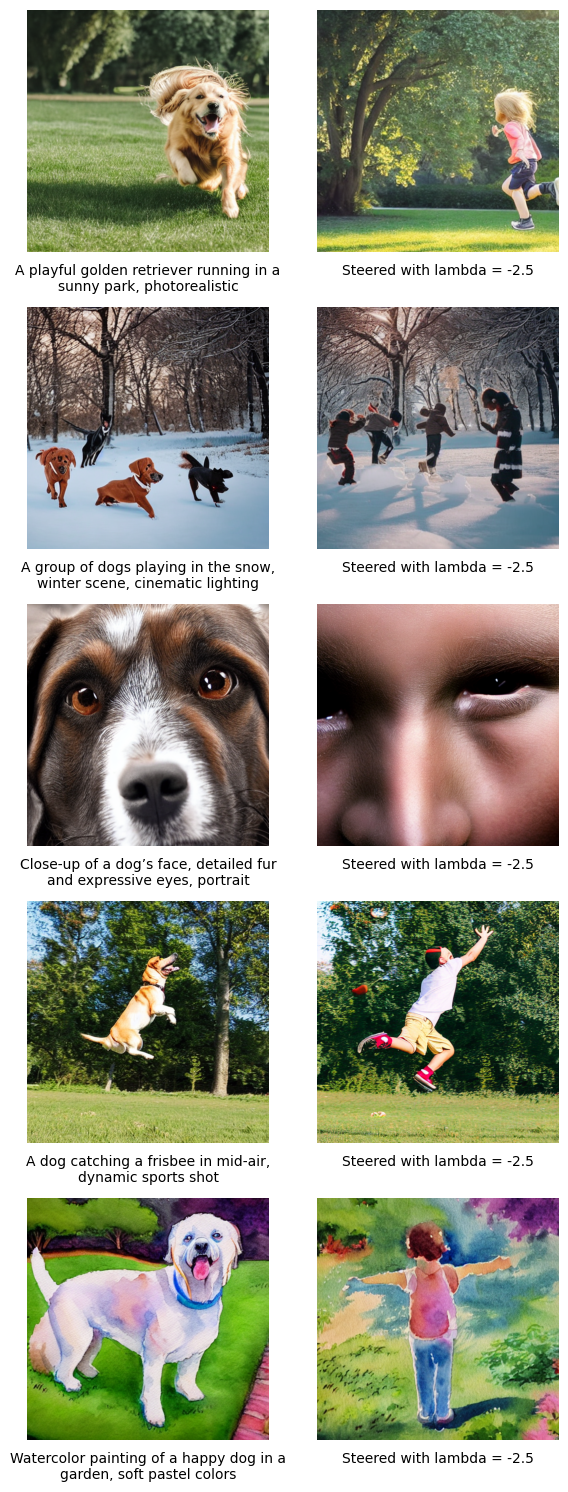

In [22]:
images = []
prompts = []

for idx, base_img in enumerate(base_images):
    images.append(base_img)
    images.append(steered_images[idx])
    
    prompts.append(forget_prompts[idx])
    prompts.append(f'Steered with lambda = {LAMBDA}')


show_images(images, prompts)